# SanityChecker: 

### Patch Clamp Electrophysiology Notebook that implements low level methods from PatchAnalyzer to do patch analysis without a GUI.



In [308]:
# ------------------------------------------------------------------
# Make the *outer* repo folder importable
# ------------------------------------------------------------------
import sys
from pathlib import Path
import pandas as pd

nb_path   = Path.cwd()                 # e.g. …/ProjectRoot/PatchAnalyzer/AnalysisTesting
repo_root = nb_path.parents[1]         # go up two levels → …/ProjectRoot/

if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# sanity check (optional)
# print("repo root on sys.path:", repo_root)


In [309]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as W
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


# ------------------------------------------------------------------
# PatchAnalyzer helpers
# ------------------------------------------------------------------
from PatchAnalyzer.models.data_loader import load_metadata
from PatchAnalyzer.models.ephys_loader import (
    load_voltage_traces_for_indices,
    load_current_traces,          # nested CC helper
)
from PatchAnalyzer.utils.passives import (
    compute_passive_params,       # VC
    compute_cc_passive_params,    # CC
)
from PatchAnalyzer.utils.spike_params import (
    Sweep,
    calc_firing_curve,
    calc_spike_metrics,
)

plt.rcParams["figure.dpi"] = 110


In [310]:
# Select multiple experiment dirs the same way the GUI’s WelcomePage does
exp_dirs = [
    # Path(r"C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_06_25-12_09"),   # TODO – add as many as you like
    # Path(r"C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_06_25-13_07"),
    # Path(r"C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_06_25-13_30"),
    Path(r"C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_06_25-15_58"),
    # Path(r"C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_07_02-13_09"),
    
    # Path("/path/to/another/experiment"),
]
exp_dirs


[WindowsPath('C:/Users/sa-forest/Documents/GitHub/PatchAnalyzer/Data/Test/2025_06_25-15_58')]

In [311]:
# ---------------------------------------------------------------------------
# Build `cells`  →  key = (exp_dir, (x,y,z))
#                   val = {"vc": [...], "cc": {cell_id: {current: trace}} }
# ---------------------------------------------------------------------------
cells = {}

meta_frames = []
for exp in exp_dirs:
    try:
        meta_frames.append(load_metadata([exp]))
    except ValueError:
        print(f"⚠  No CellMetadata in {exp}")

if not meta_frames:
    raise RuntimeError("No cell metadata loaded – check folder paths.")

meta_df = pd.concat(meta_frames, ignore_index=True)

idx_col = "indices" if "indices" in meta_df.columns else "index"
if idx_col not in meta_df.columns:
    raise RuntimeError("Neither “indices” nor “index” column found in metadata")

for coord, sub in meta_df.groupby(["stage_x", "stage_y", "stage_z"]):
    exp_dir       = Path(sub["src_dir"].iloc[0])
    sweep_indices = sub[idx_col].tolist()        # list[int]  → cell numbers

    # --- Voltage-clamp
    vc_traces = [
        (t, cmd, rsp)
        for idx in sweep_indices
        for (t, cmd, rsp) in load_voltage_traces_for_indices(exp_dir, [idx]).values()
    ]

    # --- Current-clamp   nested {cell_id ▶ current ▶ trace}
    cc_nested = load_current_traces(exp_dir, sweep_indices)

    cells[(exp_dir, coord)] = dict(vc=vc_traces, cc=cc_nested)

print(f"Found {len(cells)} unique physical cells")


2025-07-15 16:06:18,299 [INFO] Loaded 6 rows from C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_06_25-15_58\CellMetadata\cell_metadata.csv
Found 2 unique physical cells


In [312]:
for (exp, coord), d in cells.items():
    n_vc = len(d['vc'])
    n_cc = sum(len(cur_dict) for cur_dict in d['cc'].values())
    print(f"{exp.name} {coord}: {n_vc} VC traces, {n_cc} CC traces")
    for cid, cur_dict in d['cc'].items():
        print(f"    cell {cid}: {len(cur_dict)} CC sweeps")



2025_06_25-15_58 (np.float64(2191.924664667212), np.float64(48866.046024274525), np.float64(20327.8)): 5 VC traces, 151 CC traces
    cell 2: 23 CC sweeps
    cell 3: 25 CC sweeps
    cell 4: 33 CC sweeps
    cell 5: 35 CC sweeps
    cell 6: 35 CC sweeps
2025_06_25-15_58 (np.float64(2906.2965543591563), np.float64(45936.06428926166), np.float64(20372.9)): 1 VC traces, 5 CC traces
    cell 1: 5 CC sweeps


In [313]:
def find_coord_for_cell(cells_dict, exp_dir, cell_id):
    """
    Return the (exp_dir, coord) key whose CC‑data contains *cell_id*.
    Raises RuntimeError if not found or if duplicates exist
    (duplicates should never happen given your data guarantees).
    """
    matches = [k for k, v in cells_dict.items()
               if k[0] == exp_dir and cell_id in v["cc"]]

    if not matches:
        raise RuntimeError(f"Cell {cell_id} not found in {exp_dir.name}")
    if len(matches) > 1:
        raise RuntimeError(
            f"Cell {cell_id} appears under multiple coordinates – "
            "check the dataset consistency."
        )
    return matches[0]          # the single matching coord_key


In [314]:
# ---------- choose the physical cell & recorder cell‑number -------------
print(f"Available experiments: {[e.name for e in exp_dirs]}")
exp_dir  = exp_dirs[0]           # pick your experiment dir
cell_id  = 4
                   # pick your cell number
print(f"Chosen: {exp_dir.name}, cell_id = {cell_id}")

# ---------- locate the correct (exp_dir, coord) -------------------------
coord_key = find_coord_for_cell(cells, exp_dir, cell_id)
cc_dict   = cells[coord_key]["cc"]            # {cell_id: {current: trace}}
sweeps    = cc_dict[cell_id]                  # guaranteed to exist

print(f"Found {len(sweeps)} CC sweeps for cell {cell_id} at coord {coord_key[1]}")


Available experiments: ['2025_06_25-15_58']
Chosen: 2025_06_25-15_58, cell_id = 4
Found 33 CC sweeps for cell 4 at coord (np.float64(2191.924664667212), np.float64(48866.046024274525), np.float64(20327.8))


In [315]:
# ────────── VC passive extraction for this physical cell ──────────
from PatchAnalyzer.utils.passives import compute_passive_params
import numpy as np

# locate the (exp_dir, coord) key that matches this experiment
coord_key = next(k for k in cells if k[0] == exp_dir)
data      = cells[coord_key]

vc_traces = data["vc"]                    # list of (t, cmd, rsp)
vc_outs   = [compute_passive_params(*tr) for tr in vc_traces]
vc_valid  = [o for o in vc_outs if all(v is not None for v in o)]

if vc_valid:
    Ra_mohm, Rm_mohm, Cm_pf = map(np.mean, zip(*vc_valid))
    print(f"Voltage‑clamp (mean of {len(vc_valid)} fits):")
    print(f"  Ra = {Ra_mohm:.1f} MΩ   Rm = {Rm_mohm:.1f} MΩ   Cm = {Cm_pf:.1f} pF")
else:
    Ra_mohm = Rm_mohm = Cm_pf = np.nan
    print("No successful VC passive fits.")

# keep these three variables for later comparison if you wish


Voltage‑clamp (mean of 5 fits):
  Ra = 36.3 MΩ   Rm = 48.1 MΩ   Cm = 139.3 pF


In [316]:
# ─── quick sanity check ───
print("▶ exp_dir:", exp_dir)
print("▶ cell_id:", cell_id, type(cell_id))

# 1) Which (exp_dir, coord) keys contain this cell_id?
matches = [k for k, v in cells.items()
           if k[0] == exp_dir and cell_id in v["cc"]]
print("\n▶ coord matches for cell_id:", matches)

# 2) If *one* match, peek into its CC dict
if len(matches) == 1:
    coord_key = matches[0]
    cc_dict = cells[coord_key]["cc"]
    print("    CC keys present:", list(cc_dict.keys())[:10], "…")
    print(f"    # currents for cell {cell_id}:",
          len(cc_dict[cell_id]) if cell_id in cc_dict else "NOT PRESENT")
else:
    print("⚠  None or multiple coord matches — see list above")

# 3) Is there any other part of the notebook still setting coord_key?
print("\n▶ coord_key defined in globals?", 'coord_key' in globals())
if 'coord_key' in globals():
    print("    current coord_key value:", coord_key)


▶ exp_dir: C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_06_25-15_58
▶ cell_id: 4 <class 'int'>

▶ coord matches for cell_id: [(WindowsPath('C:/Users/sa-forest/Documents/GitHub/PatchAnalyzer/Data/Test/2025_06_25-15_58'), (np.float64(2191.924664667212), np.float64(48866.046024274525), np.float64(20327.8)))]
    CC keys present: [2, 3, 4, 5, 6] …
    # currents for cell 4: 33

▶ coord_key defined in globals? True
    current coord_key value: (WindowsPath('C:/Users/sa-forest/Documents/GitHub/PatchAnalyzer/Data/Test/2025_06_25-15_58'), (np.float64(2191.924664667212), np.float64(48866.046024274525), np.float64(20327.8)))


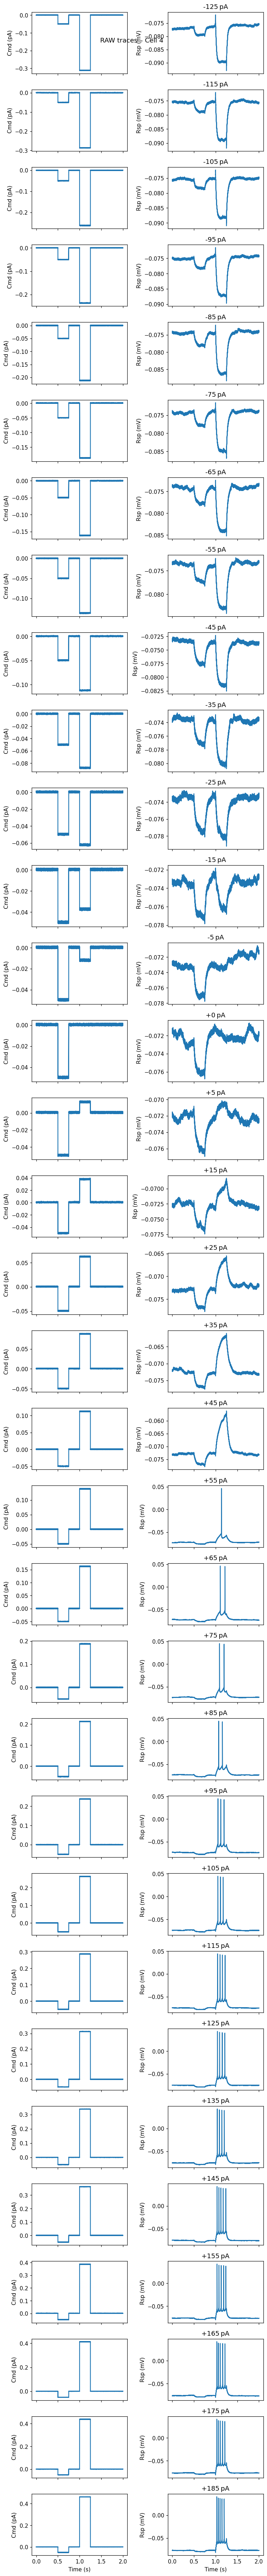

In [317]:
# ----------- gather sweeps for *one* (exp_dir, coord) --------------------
key     = coord_key                    # re‑use variable from the VC cell
cc_dict = cells[key]["cc"]             # {cell_id: {current: trace}}
sweeps  = cc_dict.get(cell_id, {})     # all sweeps for this cell_id
if not sweeps:
    raise RuntimeError(f"No CC sweeps found for cell {cell_id}")

# ---------- plot *entire* command/response for every sweep ---------------
fig, axs = plt.subplots(len(sweeps), 2,
                        figsize=(7, 2*len(sweeps)), sharex='col')
for (I, (t, cmd, rsp)), ax in zip(sorted(sweeps.items()), axs):
    ax[0].plot(t, cmd);  ax[0].set_ylabel("Cmd (pA)")
    ax[1].plot(t, rsp);  ax[1].set_ylabel("Rsp (mV)")
    ax[1].set_title(f"{I:+.0f} pA")
for a in axs[-1]:
    a.set_xlabel("Time (s)")
plt.suptitle(f"RAW traces – Cell {cell_id}"); plt.tight_layout(); plt.show()


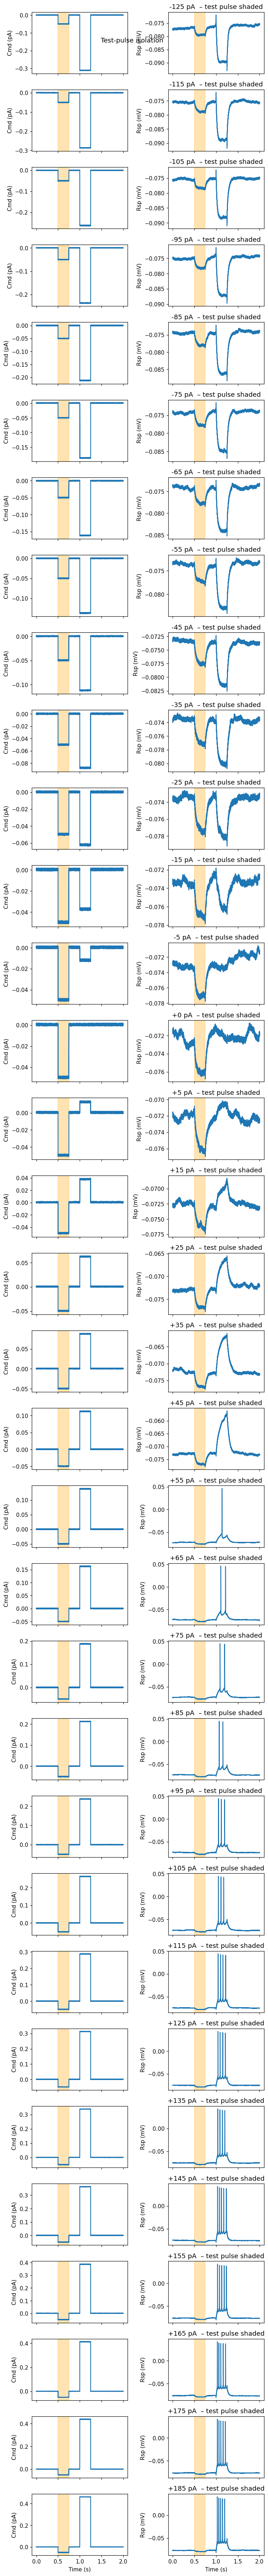

In [318]:
# helper --------------------------------------------------------------
def find_test_pulse(cmd, edge_frac=0.05, min_sep_pts=5):
    """
    Locate the FIRST current-step (“test pulse”) in *cmd*.

    NEW LOGIC  ▸ purely amplitude-based
        • works for any polarity (test and main pulse can both be –ve or +ve)
        • adaptive threshold derived from baseline MAD, so large later
          pulses no longer mask the small –20 pA test pulse
    Returns
    -------
    (s, e) : tuple[int | None, int | None]
             indices of the test-pulse start / end,
             or (None, None) if nothing crosses the threshold.
    """
    import numpy as np

    cmd = np.asarray(cmd)
    if cmd.size == 0:
        return None, None

    # ── 1  baseline (first 5 %) & robust σ estimate ──────────────────────
    n_base   = max(1, int(0.05 * cmd.size))
    baseline = np.median(cmd[:n_base])

    mad      = np.median(np.abs(cmd[:n_base] - baseline))
    sigma    = 1.4826 * mad if mad > 0 else np.std(cmd[:n_base])

    # adaptive amplitude threshold (≥ 1 fA floor)
    thr = max(1e-3, sigma * (edge_frac * 100))   # edge_frac=0.05 ⇒ 5 σ

    # ── 2  mask of points “inside a pulse” ───────────────────────────────
    mask = np.abs(cmd - baseline) > thr
    idxs = np.where(mask)[0]
    if idxs.size == 0:
        return None, None

    # ── 3  contiguous runs, keep the first one meeting length criterion ─
    runs = np.split(idxs, np.where(np.diff(idxs) > 1)[0] + 1)
    runs = [r for r in runs if len(r) >= min_sep_pts]
    if not runs:
        return None, None

    s, e = int(runs[0][0]), int(runs[0][-1])
    return s, e




# truncate & visualise -------------------------------------------------
trunc_sweeps = {}      # {I: (t, cmd, rsp, s, e)}
for I, (t, cmd, rsp) in sweeps.items():
    s, e = find_test_pulse(cmd)
    if s is not None and e is not None:
        trunc_sweeps[I] = (t, cmd, rsp, s, e)
    else:
        print(f"⚠  no test pulse detected in sweep {I:+.0f} pA – skipped")

if not trunc_sweeps:
    raise RuntimeError("No sweeps contained a detectable test pulse.")

fig, axs = plt.subplots(len(trunc_sweeps), 2,
                        figsize=(7, 2*len(trunc_sweeps)), sharex='col')
for (I, (t, cmd, rsp, s, e)), ax in zip(sorted(trunc_sweeps.items()), axs):
    ax[0].plot(t, cmd); ax[0].axvspan(t[s], t[e], color='orange', alpha=.3)
    ax[0].set_ylabel("Cmd (pA)")
    ax[1].plot(t, rsp); ax[1].axvspan(t[s], t[e], color='orange', alpha=.3)
    ax[1].set_ylabel("Rsp (mV)")
    ax[1].set_title(f"{I:+.0f} pA  – test pulse shaded")
for a in axs[-1]:
    a.set_xlabel("Time (s)")
plt.suptitle("Test‑pulse isolation"); plt.tight_layout(); plt.show()



C:\Users\sa-forest\AppData\Local\Temp\ipykernel_38944\3538144691.py:13: RuntimeWarning: overflow encountered in exp
  return m * np.exp(-tau_inv * t) + b


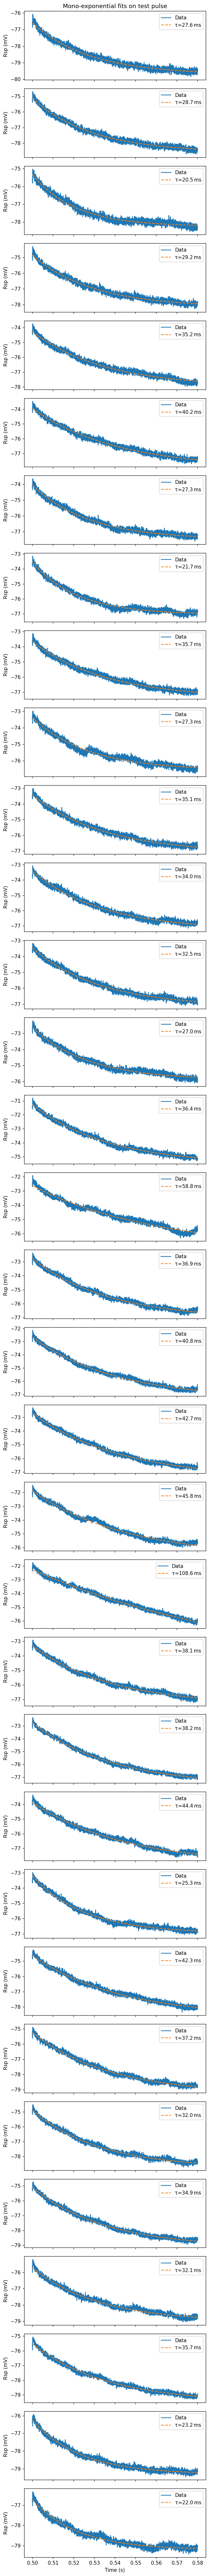

In [319]:
# --------------------------------------------------------------------------
#  Accurate passive extraction  (volts ➜ millivolts conversion)
# --------------------------------------------------------------------------
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

BASELINE_MS   = 20             # ms
PLATEAU_MS    = 20             # ms
FIT_WINDOW_MS = 80             # ms

def mono_exp(t, m, tau_inv, b):          # t in ms, returns mV
    return m * np.exp(-tau_inv * t) + b

fit_results = []

fig, axs = plt.subplots(len(trunc_sweeps), 1,
                        figsize=(6, 2.2*len(trunc_sweeps)), sharex=True)

for (I, (t, cmd, rsp, s, e)), ax in zip(sorted(trunc_sweeps.items()), axs):
    dt       = t[1] - t[0]
    pre_pts  = int(BASELINE_MS   / 1000 / dt)
    plat_pts = int(PLATEAU_MS    / 1000 / dt)
    fit_pts  = int(FIT_WINDOW_MS / 1000 / dt)

    # ------------------------ volt ➜ mV ---------------------------------
    rsp_mV = rsp * 1000.0

    V_base = np.mean(rsp_mV[max(0, s-pre_pts): s])
    V_plat = np.mean(rsp_mV[max(s, e-plat_pts): e])
    dV_mV  = V_plat - V_base                  # ≈ 1–3 mV

    I_base_pA = np.mean(cmd[max(0, s-pre_pts): s])          # already pA
    I_plat_pA = np.mean(cmd[max(s, e-plat_pts): e])         # already pA
    dI_pA     = I_plat_pA - I_base_pA


    Rin_MΩ = abs(dV_mV / dI_pA)                           # mV / pA  →  MΩ

    Xfit_ms = (t[s:s+fit_pts] - t[s]) * 1000  # ms from onset
    Yfit_mV = rsp_mV[s:s+fit_pts] - V_plat    # decays to 0 mV

    try:
        p, _ = curve_fit(mono_exp, Xfit_ms, Yfit_mV,
                         p0=(Yfit_mV[0], 10, 0), maxfev=20000)
        tau_ms = 1 / p[1]
        Cm_pF  = (tau_ms / Rin_MΩ) * 1000.0    # ms / MΩ → pF


        # --------------------- plot overlay -----------------------------
        ax.plot(t[s:s+fit_pts], Yfit_mV + V_plat, label="Data")
        ax.plot(t[s:s+fit_pts],
                mono_exp(Xfit_ms, *p) + V_plat, "--",
                label=f"τ={tau_ms:.1f} ms")
        ax.set_ylabel("Rsp (mV)"); ax.legend()

        fit_results.append(dict(
            current_pA = I,
            Rin_MOhm   = Rin_MΩ,
            tau_ms     = tau_ms,
            Cm_pF      = Cm_pF,
            Rest_mV    = V_base,     # resting potential
        ))
    except RuntimeError:
        ax.plot(t[s:s+fit_pts], Yfit_mV + V_plat, 'r', label="Fit failed")
        ax.legend()

axs[-1].set_xlabel("Time (s)")
axs[0].set_title("Mono‑exponential fits on test pulse")
plt.tight_layout(); plt.show()



In [320]:
# --------------------------------------------------------------------------
#  Summary table  (one row per sweep + MEAN)
# --------------------------------------------------------------------------
res_df = pd.DataFrame(fit_results)          # columns: current_pA, Rin_MOhm, tau_ms, Cm_pF

if not res_df.empty:
    mean_row = res_df.mean(numeric_only=True).to_dict()
    mean_row["current_pA"] = "MEAN"
    res_df = pd.concat([res_df, pd.DataFrame([mean_row])], ignore_index=True)

display(res_df)

# If you ran the VC‑Rm comparison in Cell E, the printout is already there.



current_pA   Rin_MOhm      tau_ms        Cm_pF    Rest_mV
0      -125.0  52.705796   27.595479   523.575797 -76.755998
1      -115.0  69.555801   28.716689   412.858282 -75.350372
2      -105.0  55.326821   20.507177   370.655255 -75.719009
3       -95.0  59.684014   29.234362   489.818973 -74.999054
4       -85.0  75.698662   35.169377   464.597079 -74.350097
5       -75.0  75.750916   40.197614   530.655150 -74.118153
6       -65.0  68.662113   27.311703   397.769617 -74.334935
7       -55.0  76.170180   21.734443   285.340580 -73.800401
8       -45.0  78.966340   35.668895   451.697465 -73.649553
9       -35.0  73.067433   27.279058   373.340856 -73.546538
10      -25.0  76.667144   35.071912   457.456872 -73.625013
11      -15.0  69.302872   33.966424   490.115675 -73.700964
12       -5.0  67.186282   32.541510   484.347540 -73.640925
13        0.0  64.158487   26.966816   420.315654 -72.848518
14        5.0  97.946148   36.405908   371.693106 -71.427586
15       15.0  79.683116   58.806208   738.000860 -72.738649
16       25.0  80.073119   36.877217   460.544284 -72.936962
17       35.0  86.586595   40.768766   470.843849 -72.721650
18       45.0  86.023709   42.661872   495.931560 -72.874799
19       55.0  77.422312   45.797974   591.534569 -72.293805
20       65.0  89.621739  108.581290  1211.550808 -72.278308
21       75.0  75.970674   38.109955   501.640344 -73.458492
22       85.0  83.337341   38.241584   458.876939 -73.004047
23       95.0  73.845783   44.436615   601.748849 -73.996574
24      105.0  78.496891   25.257685   321.766690 -73.539716
25      115.0  57.866359   42.315531   731.263055 -74.892029
26      125.0  66.145167   37.173331   561.996179 -75.515791
27      135.0  65.649869   32.037436   488.004568 -75.099417
28      145.0  70.489171   34.915748   495.334920 -75.447173
29      155.0  60.079116   32.138793   534.941174 -75.945697
30      165.0  66.252648   35.688131   538.667241 -75.623615
31      175.0  60.404703   23.157804   383.377496 -76.466220
32      185.0  50.360227   21.960717   436.072640 -76.943799
33       MEAN  71.792653   36.281637   501.404058 -74.171026

### 2 Active Spike Parameters calculation


Cell 4: 33 Sweep objects constructed


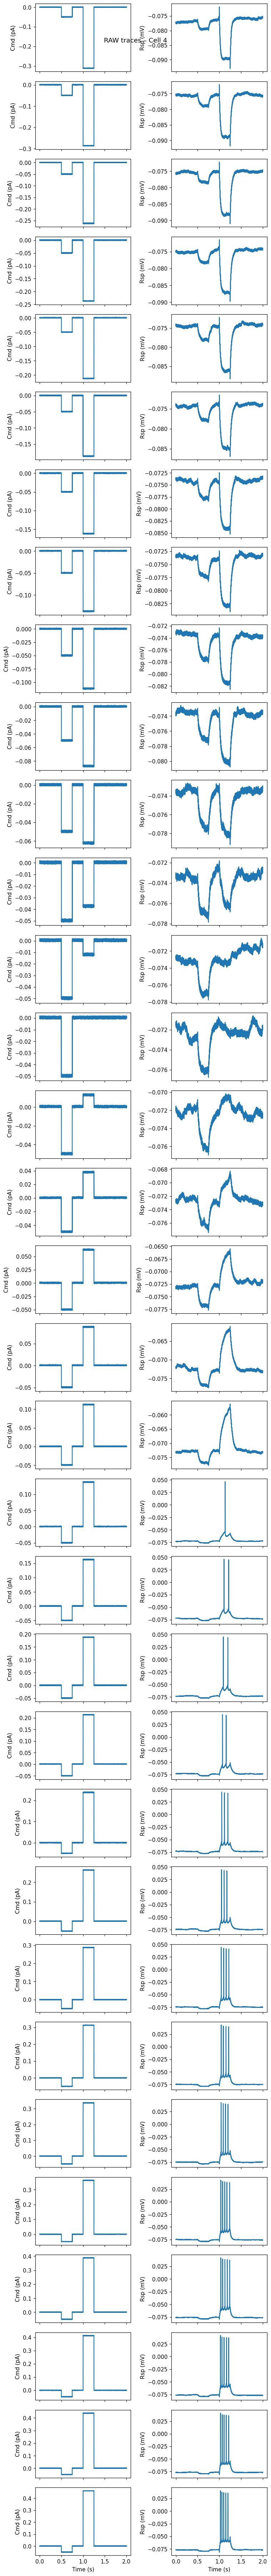

In [321]:
# %% 🔧  USER‑TUNABLE GLOBALS  🔧 ------------------------------------------------
EDGE_FRAC          = 0.15   # fraction of max |dI/dt| that counts as an edge
MIN_SEP_PTS        = 5      # min pts between start/end edges
SMOOTH_PTS         = 50     # box‑car points for spike detection
PEAK_PROMINENCE_MV = 12     # min spike prominence (mV)
DVDT_THRESH_MV_MS  = 50     # dv/dt threshold for spike threshold detection
HW_WINDOW_MS       = 3.0    # ± window for half‑width & dv/dt max (ms)
DO_NORMALISE       = True  # add NormFreq column in step‑7?

# %% 🛠️  BUILD Sweep OBJECTS  (***ONLY the chosen cell***) ----------------------
from PatchAnalyzer.utils.spike_params import Sweep

# coord_key was already defined when you ran the passive section.
# Make sure exp_dir and cell_id are still set to the cell you want.

coord_key = find_coord_for_cell(cells, exp_dir, cell_id)
cc_dict   = cells[coord_key]["cc"].get(cell_id, {})

all_sweeps: list[Sweep] = []
for (t, cmd, rsp) in cc_dict.values():
    sr = 1.0 / (t[1] - t[0])
    all_sweeps.append(
        Sweep(time=t,
              response_mV=rsp,
              command_pA=cmd,
              sample_rate=sr)
    )

print(f"Cell {cell_id}: {len(all_sweeps)} Sweep objects constructed")

# -------- plot raw traces (cmd & rsp) ----------------------------------------
fig, axs = plt.subplots(len(all_sweeps), 2,
                        figsize=(7, 2*len(all_sweeps)), sharex='col')
for sw, ax in zip(all_sweeps, axs):
    ax[0].plot(sw.time, sw.command_pA); ax[0].set_ylabel("Cmd (pA)")
    ax[1].plot(sw.time, sw.response_mV); ax[1].set_ylabel("Rsp (mV)")
axs[-1][0].set_xlabel("Time (s)"); axs[-1][1].set_xlabel("Time (s)")
plt.suptitle(f"RAW traces – Cell {cell_id}"); plt.tight_layout(); plt.show()


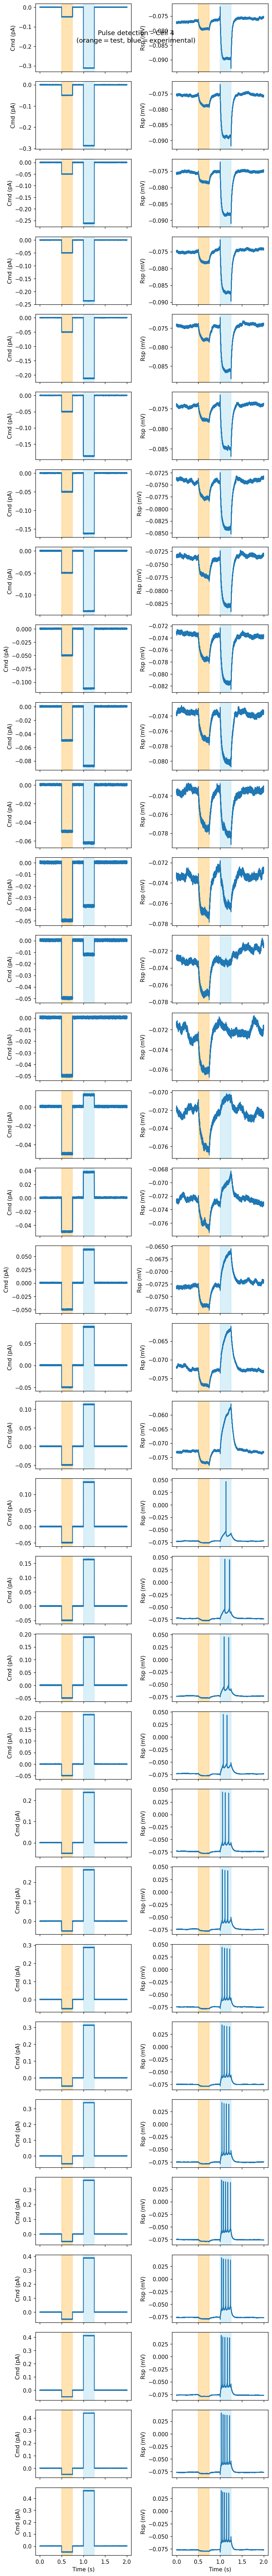

In [322]:
# %% STEP 2 – robust pulse finder  --------------------------------------------

def find_experimental_pulse(cmd, after_idx, tol_pA=0.01):
    """
    Find the FIRST region *after* `after_idx` where |cmd - baseline| > tol_pA
    (baseline = median before test pulse). Returns (start, end).
    Works for either depolarising (+pA) or hyperpolarising (–pA) steps.
    """
    baseline = np.median(cmd[:after_idx//2]) if after_idx > 10 else np.median(cmd)
    idxs = np.where(np.abs(cmd - baseline) > tol_pA)[0]
    idxs = idxs[idxs > after_idx]
    if idxs.size == 0:
        return None, None
    s = int(idxs[0])
    ends = np.where((np.abs(cmd - baseline) <= tol_pA) & (np.arange(len(cmd)) > s))[0]
    e = int(ends[0]) if ends.size else len(cmd)-1
    return s, e

pulse_bounds = []   # [(test_s, test_e, exp_s, exp_e)]
for sw in all_sweeps:
    ts, te = find_test_pulse(sw.command_pA)
    es, ee = find_experimental_pulse(sw.command_pA, after_idx=te)
    pulse_bounds.append((ts, te, es, ee))

# ------------ diagnostic plot -------------------------------------------------
fig, axs = plt.subplots(len(all_sweeps), 2,
                        figsize=(7, 2*len(all_sweeps)), sharex='col')
for (sw, (ts, te, es, ee)), ax in zip(zip(all_sweeps, pulse_bounds), axs):
    ax[0].plot(sw.time, sw.command_pA); ax[0].set_ylabel("Cmd (pA)")
    ax[1].plot(sw.time, sw.response_mV); ax[1].set_ylabel("Rsp (mV)")
    if ts is not None:
        ax[0].axvspan(sw.time[ts], sw.time[te], color='orange', alpha=.3)
        ax[1].axvspan(sw.time[ts], sw.time[te], color='orange', alpha=.3)
    if es is not None:
        ax[0].axvspan(sw.time[es], sw.time[ee], color='skyblue', alpha=.3)
        ax[1].axvspan(sw.time[es], sw.time[ee], color='skyblue', alpha=.3)
axs[-1][0].set_xlabel("Time (s)"); axs[-1][1].set_xlabel("Time (s)")
plt.suptitle(f"Pulse detection – Cell {cell_id}\n"
             "(orange = test, blue = experimental)"); plt.tight_layout(); plt.show()



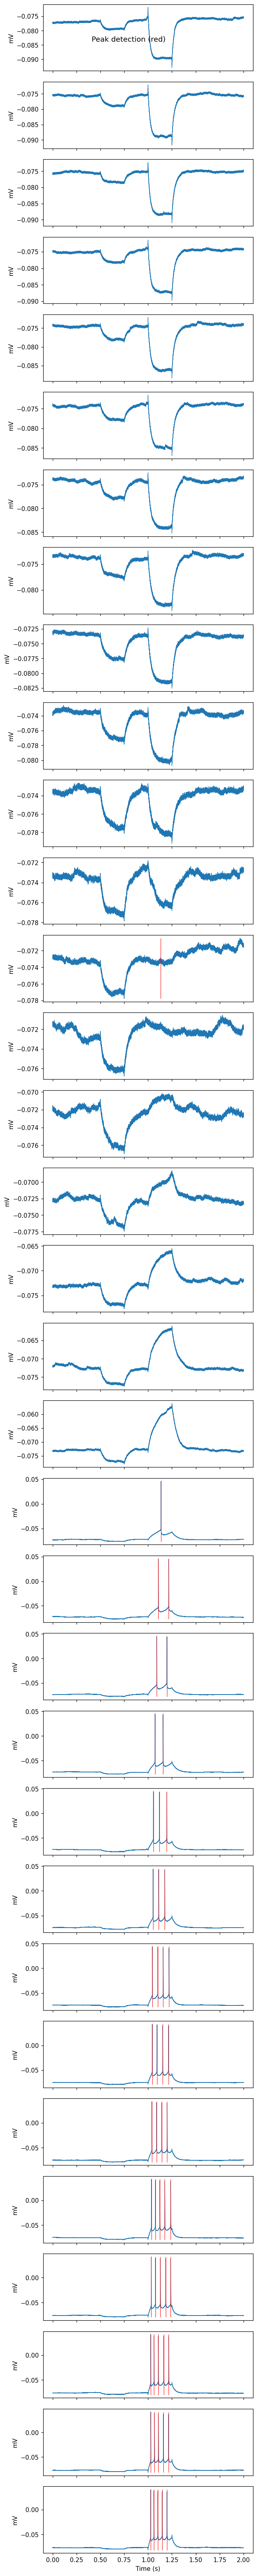

Spikes per sweep: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5]


In [323]:
# %% 📈  PEAK FINDING  (unit‑aware & more tolerant) ----------------------------
from scipy import signal
import numpy as np

def _to_mV(trace):
    """
    If the trace looks like it's in Volts (|Δ| < 1.0), convert to mV.
    Otherwise assume it's already mV.
    """
    return trace * 1e3 if np.ptp(trace) < 1.0 else trace

peak_locs_by_sweep = []

for sw, (_, _, es, ee) in zip(all_sweeps, pulse_bounds):
    if es is None:
        peak_locs_by_sweep.append(np.array([], dtype=int))
        continue

    seg = _to_mV(sw.response_mV[es:ee])                 # <-- guarantee mV
    sm  = signal.convolve(seg, np.ones(SMOOTH_PTS)/SMOOTH_PTS, mode="same")

    # If user‑set PEAK_PROMINENCE_MV is too strict, auto‑scale down
    prom = min(PEAK_PROMINENCE_MV, 0.4 * np.ptp(seg))   # 40 % of peak‑to‑peak

    peaks, _ = signal.find_peaks(
        sm,
        prominence=prom,
        height   = seg.min() + 0.05 * np.ptp(seg)       # 5 % above baseline
    )
    peak_locs_by_sweep.append(peaks.astype(int) + es)   # -> global idx (int)

# ---------- plot every sweep with red lines -----------------------------------
if not any(len(p) for p in peak_locs_by_sweep):
    print("⚠ No peaks detected – try lowering PEAK_PROMINENCE_MV or SMOOTH_PTS.")
else:
    fig, axs = plt.subplots(len(all_sweeps), 1,
                            figsize=(6, 1.8*len(all_sweeps)), sharex=True)
    for (sw, peaks), ax in zip(zip(all_sweeps, peak_locs_by_sweep), axs):
        ax.plot(sw.time, sw.response_mV, lw=.8)
        if len(peaks):
            ax.vlines(sw.time[peaks], ymin=sw.response_mV.min(),
                      ymax=sw.response_mV.max(), color='red', lw=.7)
        ax.set_ylabel("mV")
    axs[-1].set_xlabel("Time (s)")
    plt.suptitle("Peak detection (red)"); plt.tight_layout(); plt.show()

print("Spikes per sweep:", [len(p) for p in peak_locs_by_sweep])




sweep  current_inj_pA  mean_firing_frequency_Hz
0       1       -0.311603                   0.00000
1       2       -0.286548                   0.00000
2       3       -0.261879                   0.00000
3       4       -0.236718                   0.00000
4       5       -0.211918                   0.00000
5       6       -0.186766                   0.00000
6       7       -0.161778                   0.00000
7       8       -0.136715                   0.00000
8       9       -0.111917                   0.00000
9      10       -0.087329                   0.00000
10     11       -0.062177                   0.00000
11     12       -0.037203                   0.00000
12     13       -0.011835                   3.99998
13     15        0.012889                   0.00000
14     16        0.038017                   0.00000
15     17        0.062785                   0.00000
16     18        0.087822                   0.00000
17     19        0.112621                   0.00000
18     20        0.137964                   3.99998
19     21        0.162840                   7.99996
20     22        0.188085                   7.99996
21     23        0.212885                   7.99996
22     24        0.237511                  11.99994
23     25        0.262515                  11.99994
24     26        0.287463                  15.99992
25     27        0.312732                  15.99992
26     28        0.337606                  15.99992
27     29        0.362773                  19.99990
28     30        0.387575                  19.99990
29     31        0.412723                  19.99990
30     32        0.437429                  19.99990
31     33        0.462642                  19.99990

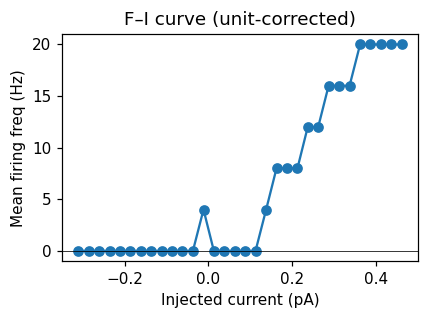

In [324]:
# %% 📊  F–I curve (unit‑safe, keeps sub‑threshold) ----------------------------
fi_rows = []

for sw_idx, ((sw, (ts, te, es, ee)), peaks) in enumerate(
        zip(zip(all_sweeps, pulse_bounds), peak_locs_by_sweep), 1):

    if es is None or ee is None:
        continue   # pulse detection failed → skip sweep entirely

    dt = 1.0 / sw.sample_rate
    stim_len_s = (ee - es) * dt

    # ---------- injected current (auto scale to pA) --------------------------
    steady = sw.command_pA[es + int(0.01/dt) : ee - int(0.01/dt)]
    inj_mean = float(np.mean(steady))
    # If the magnitude is tiny (<1e‑7 A), assume units are A → convert to pA
    if abs(inj_mean) < 1e-7:
        inj_pA = inj_mean * 1e12
    else:
        inj_pA = inj_mean                      # already pA

    # ---------- firing frequency --------------------------------------------
    mean_freq = len(peaks) / stim_len_s if stim_len_s else 0.0

    fi_rows.append(dict(
        sweep                   = sw_idx,
        current_inj_pA          = inj_pA,
        mean_firing_frequency_Hz= mean_freq,
    ))

fi_df = (pd.DataFrame(fi_rows)
           .sort_values("current_inj_pA")
           .reset_index(drop=True))
display(fi_df)

# ---------- plot --------------------------------------------------------------
plt.figure(figsize=(4,3))
plt.plot(fi_df["current_inj_pA"], fi_df["mean_firing_frequency_Hz"],
         marker='o')
plt.axhline(0, color='k', lw=.5)
plt.xlabel("Injected current (pA)")
plt.ylabel("Mean firing freq (Hz)")
plt.title("F–I curve (unit‑corrected)"); plt.tight_layout(); plt.show()



C:\Users\sa-forest\AppData\Local\Temp\ipykernel_38944\1703486494.py:25: PeakPropertyWarning: some peaks have a prominence of 0
  prominences = signal.peak_prominences(rsp_mV, [pk])[0]


sweep  spike_number  current_inj_pA    peak_mV  half_width_ms     AHP_mV  \
0     13             0       -0.011835 -73.075525       5.770029   0.287429   
1     20             0        0.137964  45.920247       0.120001  10.602951   
2     21             0        0.162840  45.600881       0.130001  10.858444   
3     21             1        0.162840  44.674720       0.110001  10.411332   
4     22             0        0.188085  44.802466       0.130001   9.932283   

   threshold_mV  dvdt_max_mV_per_ms  
0    -73.235208           15.968220  
1    -49.729870          418.367368  
2    -49.123075          418.367368  
3    -48.292723          408.786436  
4    -50.176982          405.592792

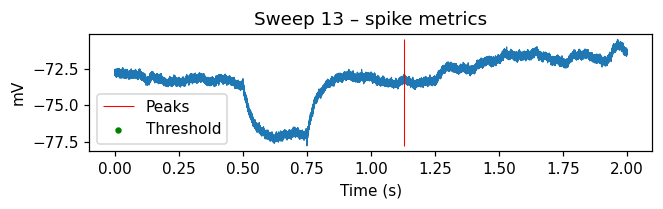

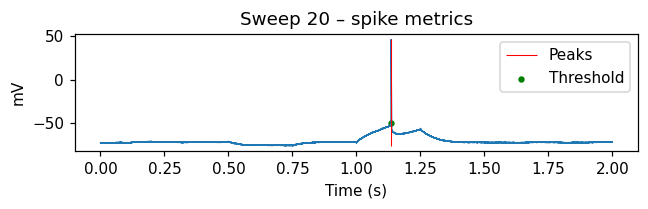

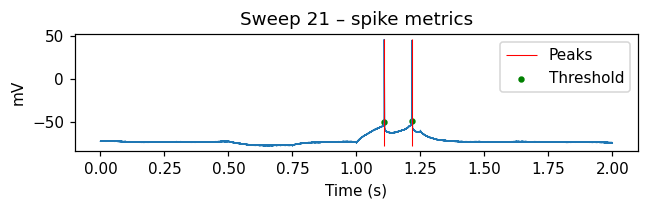

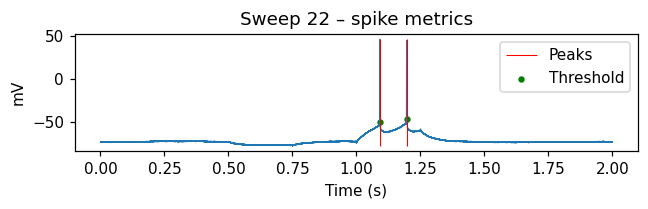

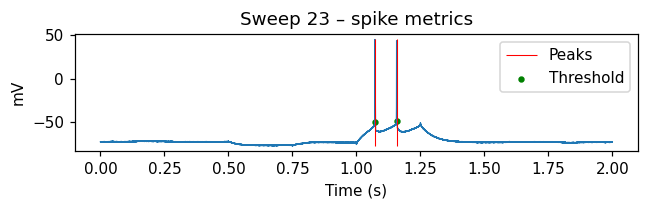

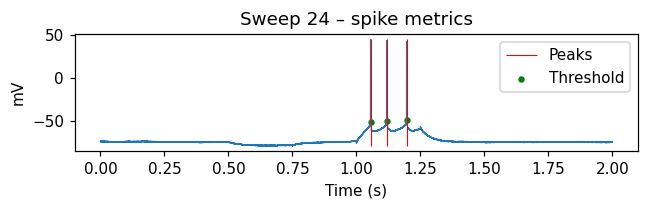

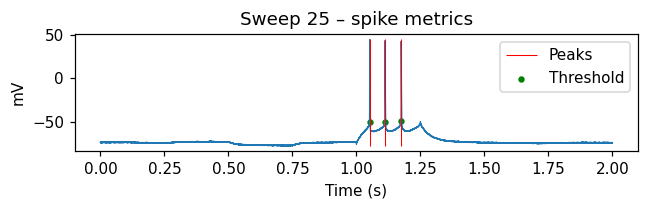

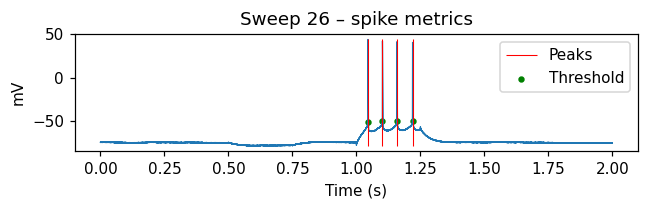

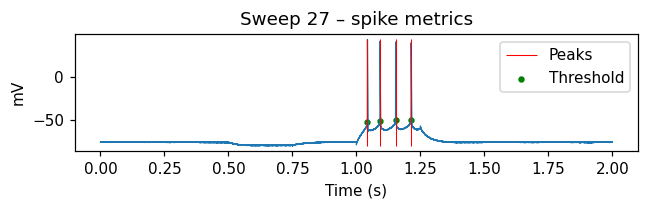

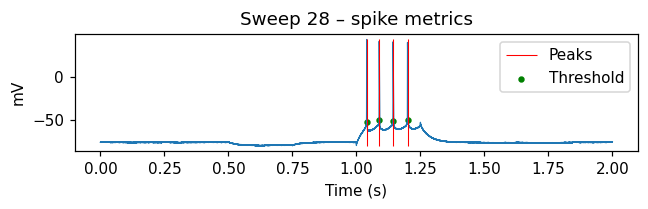

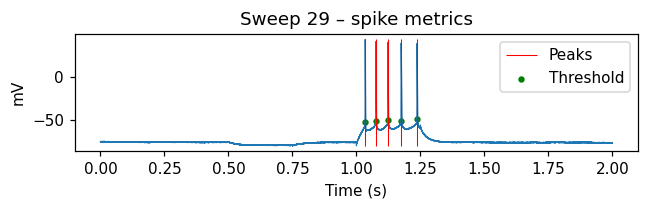

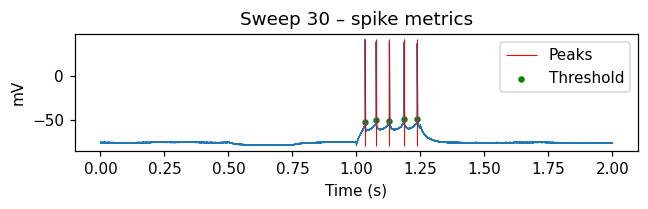

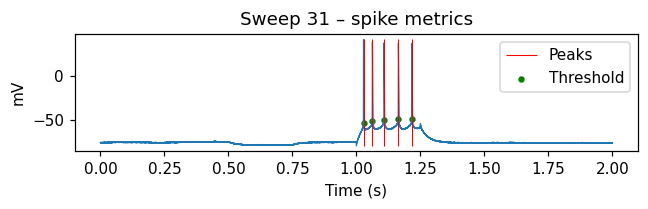

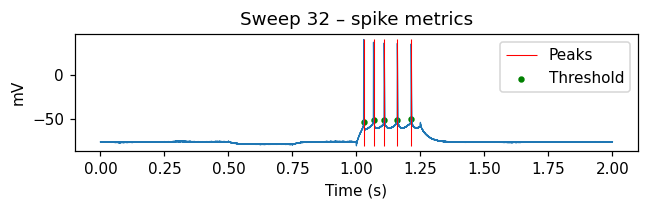

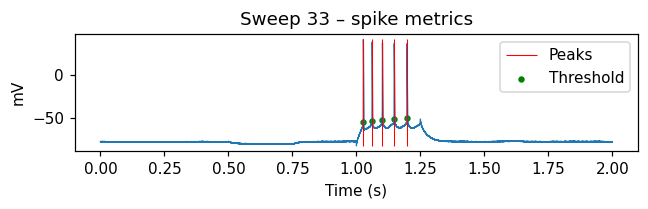

Total spikes analysed: 51


In [325]:
# %% 🧮  Spike‑by‑spike metrics  (pulse_bounds‑based) --------------------------
from scipy import signal
import numpy as np
import pandas as pd

def _to_mV(x):          # ensure units
    return x*1e3 if np.ptp(x) < 1.0 else x

all_rows = []

for sw_idx, (sw, (ts, te, es, ee), peaks) in enumerate(
        zip(all_sweeps, pulse_bounds, peak_locs_by_sweep), 1):

    if es is None or ee is None or len(peaks) == 0:
        continue    # nothing to analyse for this sweep

    rsp_mV = _to_mV(sw.response_mV)
    dt     = 1.0 / sw.sample_rate          # s
    dvdt   = np.gradient(rsp_mV, dt*1e3)   # mV/ms

    for p_num, pk in enumerate(peaks.astype(int)):      # pk = global idx
        win = int(HW_WINDOW_MS / 1000 / dt)             # ±HW_WINDOW_MS

        # ── half‑width
        prominences = signal.peak_prominences(rsp_mV, [pk])[0]
        half_val = rsp_mV[pk] - 0.5 * prominences[0]
        local = rsp_mV[pk-win : pk+win]
        xloc  = np.where(local > half_val)[0]
        if xloc.size < 2:
            continue
        half_w_ms = (xloc[-1] - xloc[0]) * dt * 1e3

        # ── threshold (last dv/dt below threshold before spike)
        dv_seg = dvdt[pk-win : pk-win//10]
        below  = np.where(dv_seg < DVDT_THRESH_MV_MS)[0]
        if below.size == 0:
            continue
        thresh_idx = pk - win + below[-1]
        thresh_mV  = rsp_mV[thresh_idx]

        # ── dv/dt max ±win
        dv_max = dvdt[pk-win : pk+win].max()

        # ── AHP (to +6 ms after peak)
        ahp = abs(rsp_mV[pk : pk + int(0.006/dt)].min() - thresh_mV)

        # ── injected current (auto‑scale to pA)
        steady = sw.command_pA[es + int(0.01/dt) : ee - int(0.01/dt)]
        inj_mean = float(np.mean(steady))
        inj_pA   = inj_mean*1e12 if abs(inj_mean) < 1e-7 else inj_mean

        all_rows.append(dict(
            sweep              = sw_idx,
            spike_number       = p_num,
            current_inj_pA     = inj_pA,
            peak_mV            = rsp_mV[pk],
            half_width_ms      = half_w_ms,
            AHP_mV             = ahp,
            threshold_mV       = thresh_mV,
            dvdt_max_mV_per_ms = dv_max,
        ))

spk_df = pd.DataFrame(all_rows)
display(spk_df.head())

# -------- diagnostic plot for every spike ------------------------------------
for sw_idx, sw in enumerate(all_sweeps, 1):
    one = spk_df[spk_df["sweep"] == sw_idx]
    if one.empty:
        continue
    plt.figure(figsize=(6,2))
    plt.plot(sw.time, _to_mV(sw.response_mV), lw=.8)
    pk_idx = one["spike_number"].values.astype(int)
    pk_glb = peak_locs_by_sweep[sw_idx-1][pk_idx]
    plt.vlines(sw.time[pk_glb], ymin=_to_mV(sw.response_mV).min(),
               ymax=_to_mV(sw.response_mV).max(),
               color='red', lw=.7, label="Peaks")
    plt.scatter(sw.time[pk_glb], one["threshold_mV"],
                c='green', s=10, label="Threshold")
    plt.ylabel("mV"); plt.xlabel("Time (s)")
    plt.title(f"Sweep {sw_idx} – spike metrics"); plt.legend()
    plt.tight_layout(); plt.show()

print(f"Total spikes analysed: {len(spk_df)}")



In [326]:
# %% 🗒️  SUMMARY TABLES  --------------------------------------------------------
print("F–I table:")
display(fi_df)

print("\nSpike‑metrics table:")
display(spk_df)

print(f"\nTotal spikes analysed: {len(spk_df)}")


F–I table:


sweep  current_inj_pA  mean_firing_frequency_Hz
0       1       -0.311603                   0.00000
1       2       -0.286548                   0.00000
2       3       -0.261879                   0.00000
3       4       -0.236718                   0.00000
4       5       -0.211918                   0.00000
5       6       -0.186766                   0.00000
6       7       -0.161778                   0.00000
7       8       -0.136715                   0.00000
8       9       -0.111917                   0.00000
9      10       -0.087329                   0.00000
10     11       -0.062177                   0.00000
11     12       -0.037203                   0.00000
12     13       -0.011835                   3.99998
13     15        0.012889                   0.00000
14     16        0.038017                   0.00000
15     17        0.062785                   0.00000
16     18        0.087822                   0.00000
17     19        0.112621                   0.00000
18     20        0.137964                   3.99998
19     21        0.162840                   7.99996
20     22        0.188085                   7.99996
21     23        0.212885                   7.99996
22     24        0.237511                  11.99994
23     25        0.262515                  11.99994
24     26        0.287463                  15.99992
25     27        0.312732                  15.99992
26     28        0.337606                  15.99992
27     29        0.362773                  19.99990
28     30        0.387575                  19.99990
29     31        0.412723                  19.99990
30     32        0.437429                  19.99990
31     33        0.462642                  19.99990


Spike‑metrics table:


sweep  spike_number  current_inj_pA    peak_mV  half_width_ms     AHP_mV  \
0      13             0       -0.011835 -73.075525       5.770029   0.287429   
1      20             0        0.137964  45.920247       0.120001  10.602951   
2      21             0        0.162840  45.600881       0.130001  10.858444   
3      21             1        0.162840  44.674720       0.110001  10.411332   
4      22             0        0.188085  44.802466       0.130001   9.932283   
5      22             1        0.188085  43.684685       0.100001  11.497176   
6      23             0        0.212885  44.674720       0.100001  10.475205   
7      23             1        0.212885  42.918207       0.130001   9.580980   
8      24             0        0.237511  44.035988       0.130001  11.082000   
9      24             1        0.237511  43.014016       0.120001   9.485170   
10     24             2        0.237511  41.960109       0.130001   9.229677   
11     25             0        0.262515  43.652748       0.120001  10.858444   
12     25             1        0.262515  42.503031       0.110001   8.974185   
13     25             2        0.262515  41.481060       0.130001   8.367389   
14     26             0        0.287463  43.620812       0.120001  10.539078   
15     26             1        0.287463  41.736552       0.110001   9.708726   
16     26             2        0.287463  40.970074       0.110001   8.718692   
17     26             3        0.287463  40.331342       0.130001   8.303516   
18     27             0        0.312732  42.886270       0.110001   9.804536   
19     27             1        0.312732  41.033947       0.130001   9.038058   
20     27             2        0.312732  40.043913       0.120001   9.293551   
21     27             3        0.312732  39.277434       0.130001   7.760594   
22     28             0        0.337606  42.375284       0.120001   9.804536   
23     28             1        0.337606  40.171659       0.130001   9.389360   
24     28             2        0.337606  39.692610       0.110001   7.792530   
25     28             3        0.337606  38.894195       0.130001   7.057989   
26     29             0        0.362773  41.960109       0.120001   9.868409   
27     29             1        0.362773  39.469054       0.150001   8.750628   
28     29             2        0.362773  39.053878       0.100001   8.048023   
29     29             3        0.362773  38.159653       0.120001   6.515066   
30     29             4        0.362773  37.584794       0.120001   8.527072   
31     30             0        0.387575  41.704616       0.090000   9.804536   
32     30             1        0.387575  38.830322       0.150001   8.974185   
33     30             2        0.387575  38.191590       0.110001   8.048023   
34     30             3        0.387575  37.999970       0.120001   8.367389   
35     30             4        0.387575  37.041872       0.120001   7.249608   
36     31             0        0.412723  41.257503       0.110001   8.718692   
37     31             1        0.412723  38.063843       0.130001   8.431262   
38     31             2        0.412723  37.137682       0.120001   8.016087   
39     31             3        0.412723  36.850253       0.140001   8.590945   
40     31             4        0.412723  36.467013       0.120001   7.792530   
41     32             0        0.437429  40.842328       0.100001   8.910311   
42     32             1        0.437429  37.680604       0.110001   8.622882   
43     32             2        0.437429  36.754443       0.130001   6.642813   
44     32             3        0.437429  36.115711       0.130001   6.738623   
45     32             4        0.437429  35.796345       0.130001   7.377355   
46     33             0        0.462642  39.916166       0.130001   9.229677   
47     33             1        0.462642  37.041872       0.120001   7.760594   
48     33             2        0.462642  36.019901       0.130001   7.505101   
49  


Total spikes analysed: 51


Normalised using Cm = 139.3 pF

Normalised F–I table:


sweep  current_inj_pA  mean_firing_frequency_Hz  NormFreq_Hz_per_pA_per_pF
0       1       -0.311603                   0.00000                  -0.000000
1       2       -0.286548                   0.00000                  -0.000000
2       3       -0.261879                   0.00000                  -0.000000
3       4       -0.236718                   0.00000                  -0.000000
4       5       -0.211918                   0.00000                  -0.000000
5       6       -0.186766                   0.00000                  -0.000000
6       7       -0.161778                   0.00000                  -0.000000
7       8       -0.136715                   0.00000                  -0.000000
8       9       -0.111917                   0.00000                  -0.000000
9      10       -0.087329                   0.00000                  -0.000000
10     11       -0.062177                   0.00000                  -0.000000
11     12       -0.037203                   0.00000                  -0.000000
12     13       -0.011835                   3.99998              -47068.202185
13     15        0.012889                   0.00000                   0.000000
14     16        0.038017                   0.00000                   0.000000
15     17        0.062785                   0.00000                   0.000000
16     18        0.087822                   0.00000                   0.000000
17     19        0.112621                   0.00000                   0.000000
18     20        0.137964                   3.99998                4037.516229
19     21        0.162840                   7.99996                6841.477405
20     22        0.188085                   7.99996                5923.224888
21     23        0.212885                   7.99996                5233.188508
22     24        0.237511                  11.99994                7035.880382
23     25        0.262515                  11.99994                6365.734777
24     26        0.287463                  15.99992                7751.026306
25     27        0.312732                  15.99992                7124.754489
26     28        0.337606                  15.99992                6599.815969
27     29        0.362773                  19.99990                7677.435853
28     30        0.387575                  19.99990                7186.144643
29     31        0.412723                  19.99990                6748.275292
30     32        0.437429                  19.99990                6367.127720
31     33        0.462642                  19.99990                6020.144933

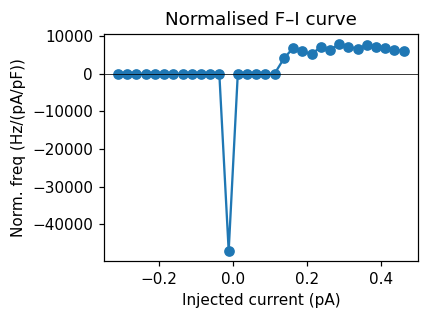

In [327]:
# %% ⚖️  NORMALISATION (optional)  ---------------------------------------------
if DO_NORMALISE and not fi_df.empty:
# take capacitance value from VC section if available, else mean of CC fits
    if 'Cm_pf' in globals() and not np.isnan(Cm_pf):
        Cm_used = Cm_pf
    elif not spk_df.empty:
        Cm_used = spk_df["current_inj_pA"].mean() / (spk_df["dvdt_max_mV_per_ms"].mean() / 1000) if not spk_df.empty else np.nan
    else:
        Cm_used = np.nan

    # divide current injected at each step by Cm (pF) to get pA/pF
    if Cm_used > 0:
        fi_df["NormFreq_Hz_per_pA_per_pF"] = fi_df["mean_firing_frequency_Hz"] / (fi_df["current_inj_pA"] / Cm_used)
        spk_df["NormFreq_Hz_per_pA_per_pF"] = spk_df["dvdt_max_mV_per_ms"] / Cm_used
        print(f"Normalised using Cm = {Cm_used:.1f} pF")
    else:
        print("⚠ Cannot normalise: Cm is zero or undefined.")
    print("\nNormalised F–I table:")
    display(fi_df)

# plot normalised F–I curve if available
if DO_NORMALISE and "NormFreq_Hz_per_pA_per_pF" in fi_df.columns and not fi_df.empty:
    plt.figure(figsize=(4,3))
    plt.plot(fi_df["current_inj_pA"], fi_df["NormFreq_Hz_per_pA_per_pF"],
             marker='o')
    plt.axhline(0, color='k', lw=.5)
    plt.xlabel("Injected current (pA)")
    plt.ylabel("Norm. freq (Hz/(pA/pF))")
    plt.title("Normalised F–I curve"); plt.tight_layout(); plt.show()